<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')
import iisignature
import sys
sys.path.append("../../")
from utils.addtime import AddTime, LeadLag
from importlib import reload
import utils.experiments as experiments 
import GP_models.GP_sig_precomputed as GP_sig
import utils.signature_features as signature_features
import esig.tosig as esig
import os
from sklearn.preprocessing import StandardScaler
import unicodedata
import numpy as np
from sklearn.model_selection import StratifiedKFold

ModuleNotFoundError: No module named 'utils'

In [7]:
df_mobility = pd.read_csv('../../data/covid_data/Global_Mobility_Report.csv')
df_cases = pd.read_csv('../../data/covid_data/download')

**What the mobility data look like for one country**

In [3]:
# france = df_mobility[df_mobility.country_region=='France']
# france.index = pd.to_datetime(france['date'].values)
# france = france.groupby(['date','sub_region_1']).sum().unstack()

In [214]:
# fig, ax = plt.subplots(2,3,figsize=(30,20))
# ax = ax.ravel()
# france.retail_and_recreation_percent_change_from_baseline.plot(rot=45,ax=ax[0])
# ax[0].set_title('retail_and_recreation',fontsize=20)
# france.grocery_and_pharmacy_percent_change_from_baseline.plot(rot=45,ax=ax[1])
# ax[1].set_title('grocery_and_pharmacy',fontsize=20)
# france.parks_percent_change_from_baseline.plot(rot=45,ax=ax[2])
# ax[2].set_title('parks',fontsize=20)
# france.workplaces_percent_change_from_baseline.plot(rot=45,ax=ax[3])
# ax[3].set_title('workplaces',fontsize=20)
# france.residential_percent_change_from_baseline.plot(rot=45,ax=ax[4])
# ax[4].set_title('residential',fontsize=20)
# france.transit_stations_percent_change_from_baseline.plot(rot=45,ax=ax[5])
# ax[5].set_title('trainsit_stations',fontsize=20)


**Select countries/bags**

In [8]:
europe =['Austria','Bulgaria','Switzerland','Germany','Denmark','Estonia','Spain','Finland','France','United Kingdom','Greece','Croatia','Hungary','Ireland','Italy','Lithuania','Norway','Netherlands','Poland','Portugal','Sweden','Slovenia','Slovakia']
europe+=['Japan', 'New Zealand', 'Canada', 'Australia', 'Israel'] #'United States'

#europe = ['Germany','Spain','France','United Kingdom', 'Greece','Italy','Canada','United States','Australia','Japan','New Zealand']

Number of subregions per country

In [1]:
# for country in europe:
#     nb_reg1 = len(df_mobility[df_mobility.country_region==country].sub_region_1.unique())
#     print(country,nb_reg1)

Mapping country names from the mobility to the cases dataset

In [9]:
dico_mobility_to_cases = {}
for country in europe:
    if country in df_cases.countriesAndTerritories.unique():
        dico_mobility_to_cases[country]=country
#     elif country=='United States':
#         dico_mobility_to_cases[country]='United_States_of_America'
    elif country == 'New Zealand':
        dico_mobility_to_cases[country]='New_Zealand'
    elif country=='United Kingdom':
        dico_mobility_to_cases[country]='United_Kingdom'

**Cases dataset**

Subset the cases dataset on a selection of countries

In [10]:
df_cases_europe = df_cases[df_cases.countriesAndTerritories.isin([dico_mobility_to_cases[key] for key in dico_mobility_to_cases.keys()])]

Visualize for one country

In [23]:
# france = df_cases_europe[df_cases_europe.countriesAndTerritories=='France'][['cases','deaths','dateRep']]
# france.index = pd.to_datetime(france['dateRep'],dayfirst=True)
# france = france.sort_index()
# france[['cases','deaths']].cumsum().plot()
# plt.show()

df_cases_europe.index = pd.to_datetime(df_cases_europe['dateRep'],dayfirst=True)
df_cases_europe = df_cases_europe.sort_index()
dg = df_cases_europe.groupby(['countriesAndTerritories']).sum()
#dg[['cases']].plot()
dg[['cases']]
# df_cases_europe[['cases']].plot()
# plt.show()

,cases
countriesAndTerritories,
Australia,7045
Austria,16154
Bulgaria,2235
Canada,76991
Croatia,2226
Denmark,10927
Estonia,1774
Finland,6347
France,142411


**Creating a Dataset**

In [1029]:
bags = []
labels = []
base_name = '_percent_change_from_baseline'
coordinates = ['retail_and_recreation'+base_name,'grocery_and_pharmacy'+base_name,'parks'+base_name,'workplaces'+base_name,'residential'+base_name,'transit_stations'+base_name]
init_value = []
for c,country in enumerate(europe):

    ''' Get the label (cumulative number of cases mid May)'''
    
    country_cases = dico_mobility_to_cases[country]
    df_country_cases = df_cases_europe[df_cases_europe.countriesAndTerritories==country_cases][['cases','deaths','dateRep','popData2018']]
    df_country_cases.index = pd.to_datetime(df_country_cases['dateRep'],dayfirst=True)
    df_country_cases = df_country_cases.sort_index()
    
    df_country_cases[['cases','deaths']]=df_country_cases[['cases','deaths']].cumsum() 
    df_country_cases[['cases']] = 10000*df_country_cases['cases']/df_country_cases['popData2018'].values[0] # per 1,000 persons
    label = df_country_cases[['cases']].iloc[-1].values[0]
    labels.append(label)

    ''' Create input time series '''
    
    # This coordinate will be the same for all items of one bag 
    # it represents the number of cases up to one month before the prediction
    cases_ts = df_country_cases.loc['2020-02-15':'2020-03-25']['cases'] # already cumulative and normalized
    cases_ts = np.concatenate((cases_ts.values[0]*np.ones(85-len(cases_ts.values)),cases_ts.values)) # pad with the first value
    init_value.append(cases_ts[-1])
    # The other coordinates come from the mobility data for the country 
    df_country_mobility = df_mobility[df_mobility.country_region==country]
    
    # group by subregions
    df_country_mobility.index = pd.to_datetime(df_country_mobility['date'].values)
    df_country_mobility = df_country_mobility.sort_index()
    
    # get number of subregions
    if df_country_mobility.groupby(['date','sub_region_1']).sum().empty:
        nb_subregions = 1
        df_country_mobility['cases']=cases_ts
        #+['cases']
        bags.append([0.1*df_country_mobility[coordinates+['cases']].fillna(method='bfill').fillna(method='ffill').to_numpy()])
    else:
        df_country_mobility = df_country_mobility.groupby(['date','sub_region_1']).sum().unstack()
        nb_subregions = len(df_country_mobility.retail_and_recreation_percent_change_from_baseline.columns.unique())
        # create a bag of 6 dimensional time series
        bag = [] 
        for i in range(nb_subregions):
            sub_region = df_country_mobility[df_country_mobility.columns[i::nb_subregions]]
            if not sub_region.isnull().values.all():  
                sub_region = 0.1*sub_region.fillna(method='bfill').fillna(method='ffill')
                sub_region['cases']=cases_ts
                bag.append(sub_region.to_numpy())
        bags.append(bag)

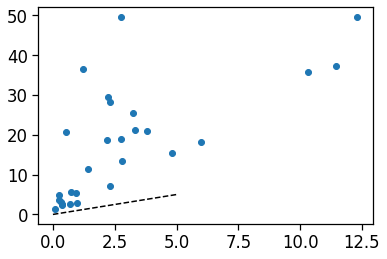

0.6917862640023418


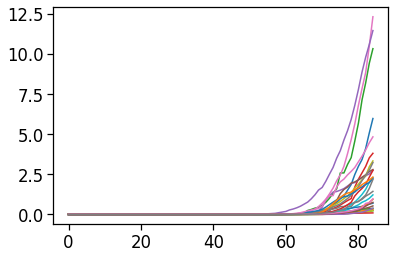

In [1030]:
from scipy.stats import pearsonr
plt.scatter(init_value,labels)
plt.plot(np.linspace(0,5,20), np.linspace(0,5,20), linestyle='dashed', color='black')
plt.show()
corr, _ = pearsonr(init_value, labels) #[bag[0][-1,-1] for bag in bags]
print(corr)
#bags[0][0].shape
for i,bag in enumerate(bags):
    plt.plot(bag[0][:,-1],label=str(i))
plt.show()

**Signature features**

In [1031]:
# signature spec
level_sig = 3
add_time_tf = AddTime()
lead_lag_tf = LeadLag([5,6,7])
sig_level1 = 5
sig_level2 = 2

# to store the features
expected_sigs = [] 
reload(signature_features)
for i,bag in enumerate(bags):
    bag = add_time_tf.fit_transform([e[:,:] for e in bag])
    bag = np.array(bag)
    bag = lead_lag_tf.fit_transform(bag)
    bag = np.array(bag)
    #expected_sig = np.mean(iisignature.sig(bag,level_sig),axis=0)
    expected_sig = signature_features.csaba_scaled_expected_sig([bag],level_sig) #signature_features.scaled_expected_sig([bag],level_sig,ilya_rescale=True,M=10)
    expected_sigs.append(expected_sig[0])#

In [1032]:
print(len(expected_sigs))
features = np.array(expected_sigs)
print('features shape: ',features.shape)
#check if the signature features are not 
print('max value across all features and all bags: ', np.max(features))

28
features shape:  (28, 1463)
max value across all features and all bags:  0.9500015918609825


In [1039]:
# stratified folds

y = np.array(labels)
bins = np.linspace(-0.1 + min(y), max(y) + 0.1, 10)
y_binned = np.digitize(y, bins)

train_indices_list = []
test_indices_list = []
skf = StratifiedKFold(n_splits=6,shuffle=True,random_state=0)
skf.get_n_splits(np.arange(len(y)),y_binned)
for train_index, test_index in skf.split(np.arange(len(y)),y_binned):
    train_indices_list.append(train_index)
    test_indices_list.append(test_index)

# select one fold
train_indices = train_indices_list[0]
test_indices = test_indices_list[0]

print('number of training bags: ', len(train_indices))
print('number of test bags: ', len(test_indices))

# Scale the (expected) signature features
# scaler = StandardScaler()
# to_fit = [features[i] for i in train_indices]
# scaler.fit(to_fit)
# features = scaler.transform(features)
# print(np.max(features))


# input ouput
labels_ = np.array(labels)[:,None]

# # Precompute the Gram matrix
K_precomputed = experiments.precompute_K(features)


number of training bags:  23
number of test bags:  5


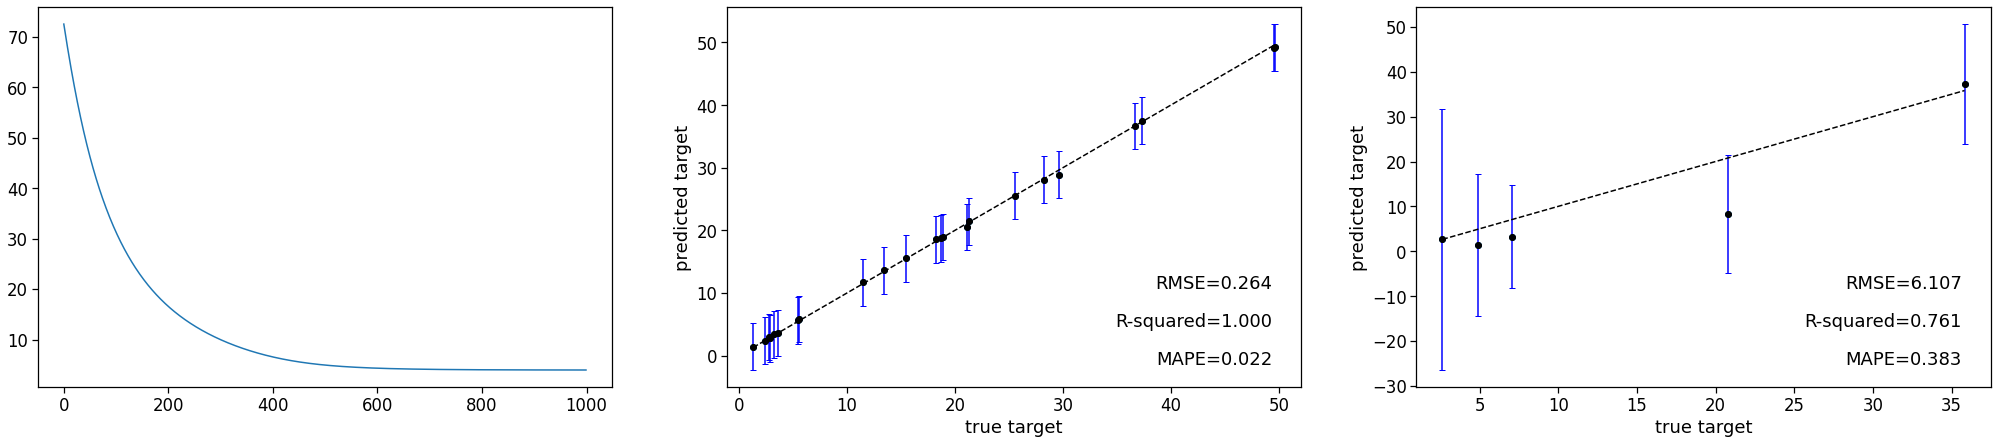

6.106809992633645


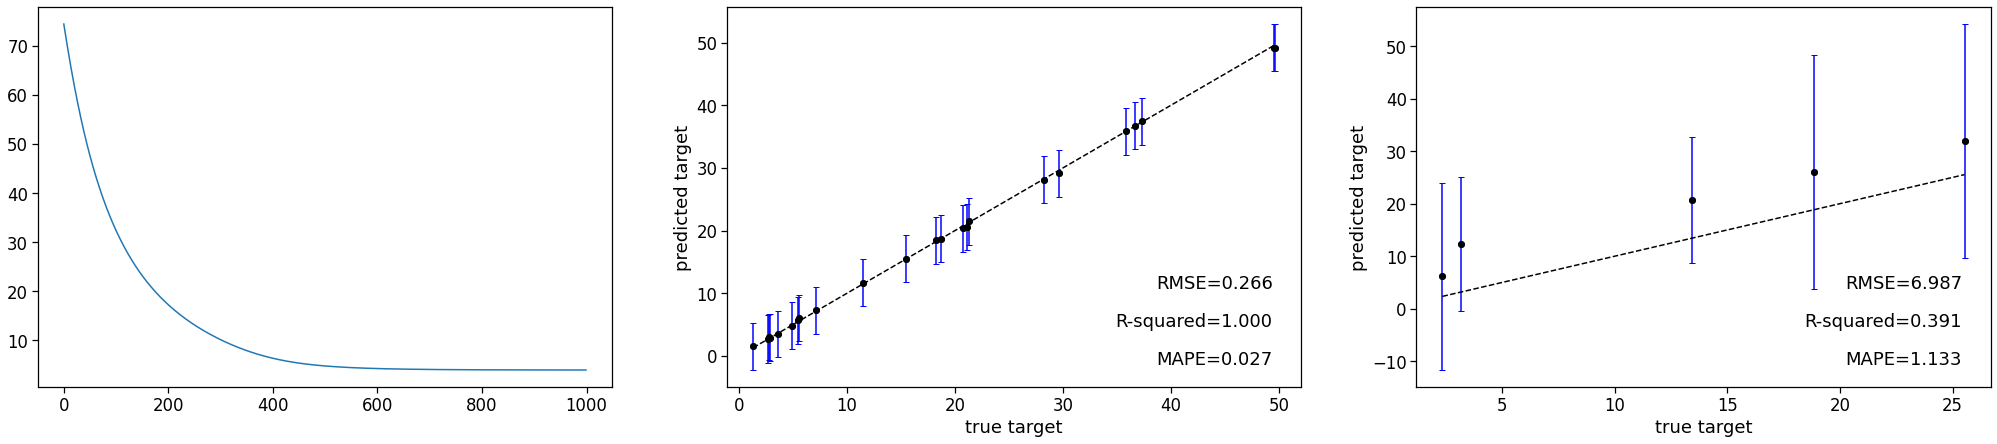

6.986659473051347


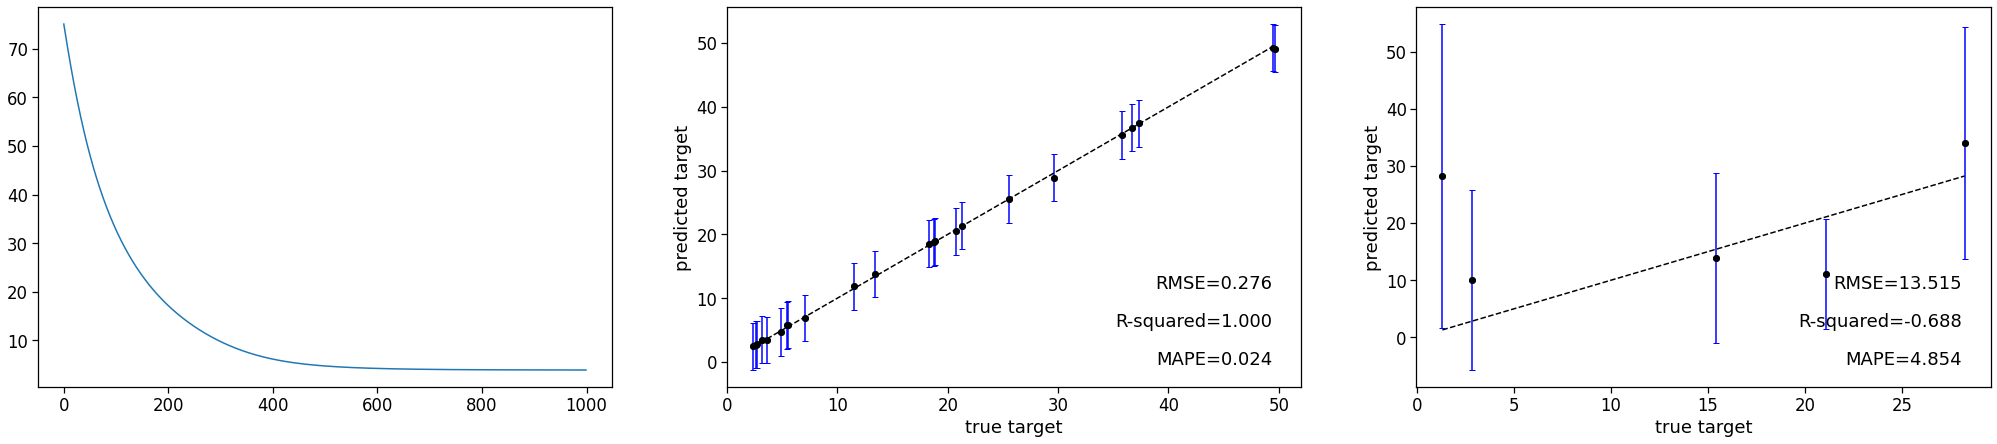

13.51452668753954


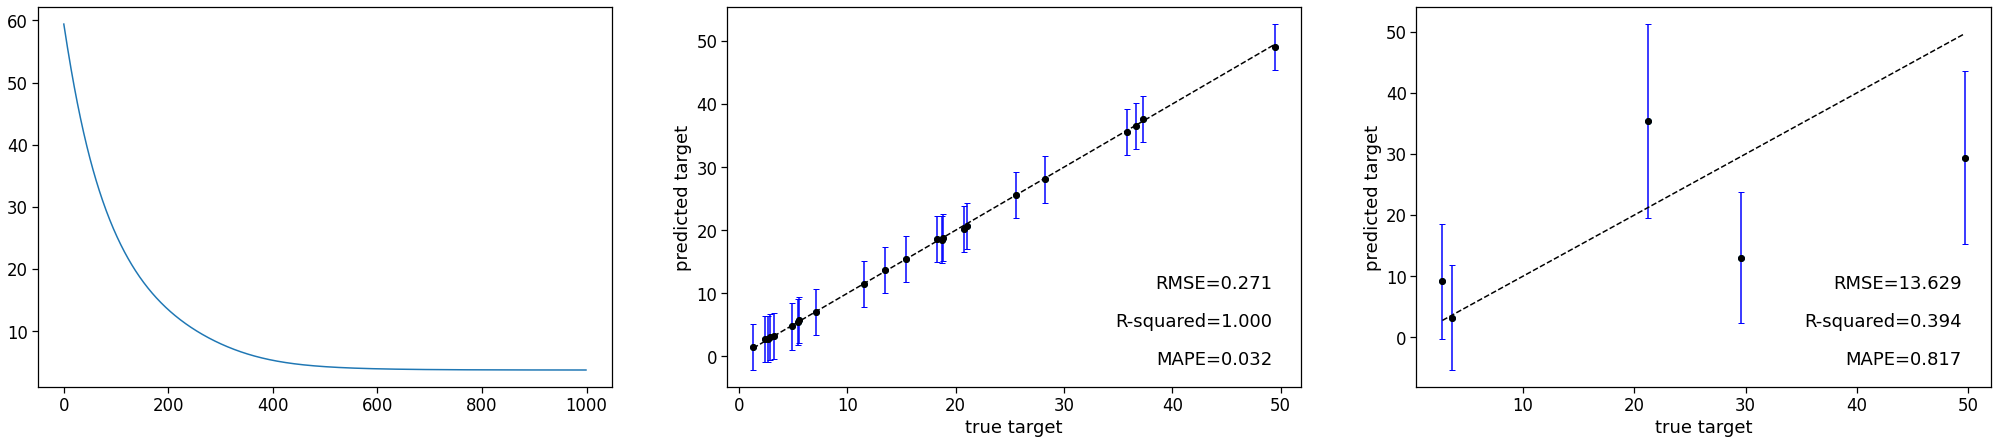

13.628529325024918


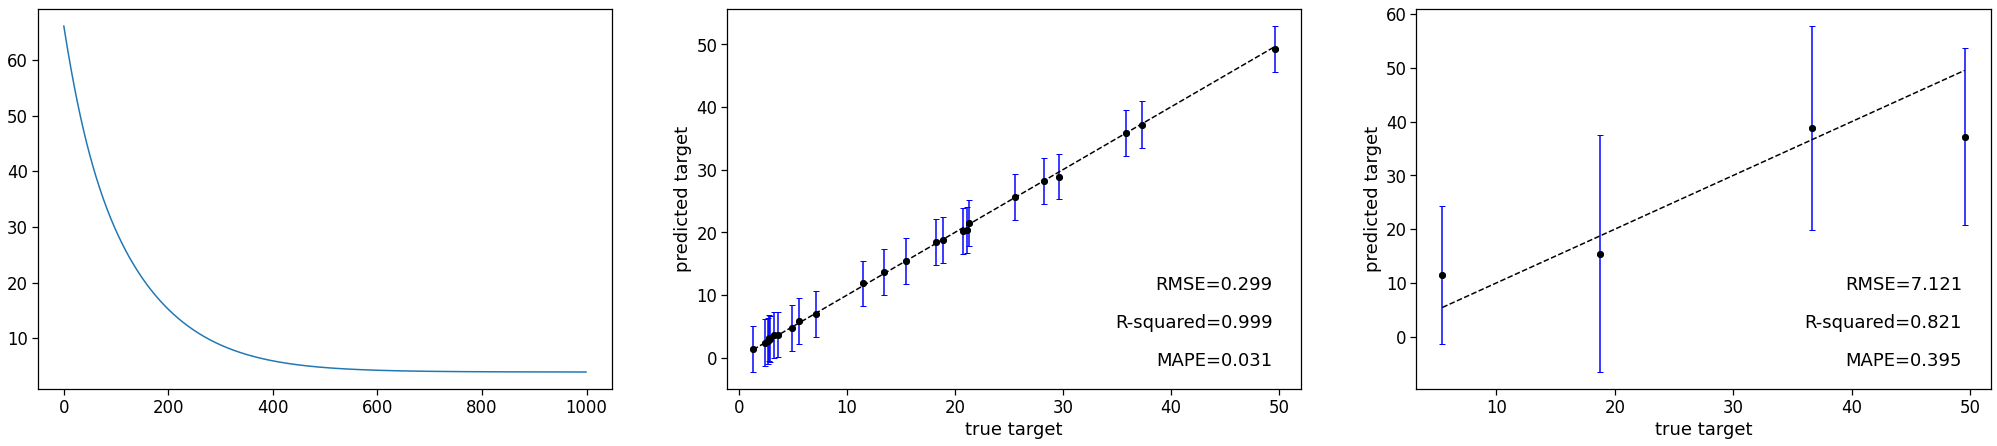

7.120692507467322


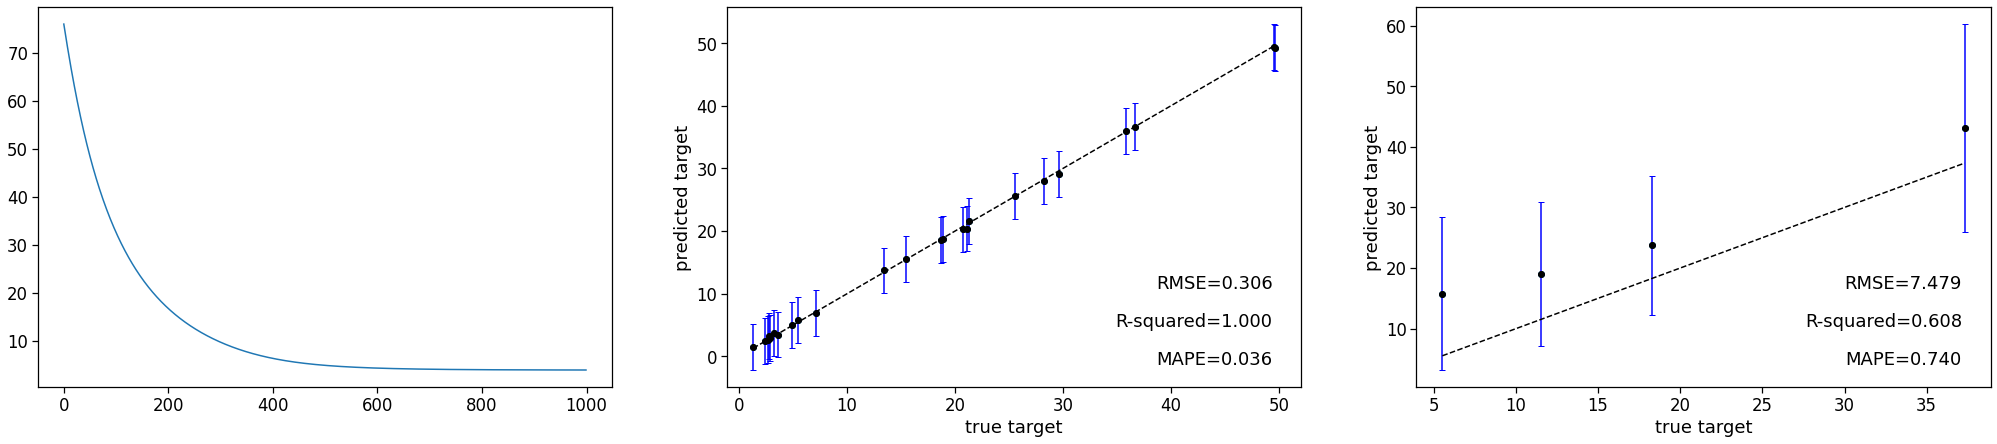

7.478636914549057


In [1043]:
reload(experiments)
reload(GP_sig)
import GP_models.GP_sig_ARD_full as GP_sig_ARD_full
reload(GP_sig_ARD_full)

r2_test_list = []
r2_train_list = []
for fold in range(6): #features.shape[0]
    
#     train_indices = [i for i in range(features.shape[0])]#train_indices_list[fold]
#     test_indices = [train_indices.pop(fold)] #test_indices_list[fold]
#     features = np.array(expected_sigs)
    train_indices = train_indices_list[fold]
    test_indices = test_indices_list[fold]
#     features = np.array(expected_sigs)
#     scaler = StandardScaler()
#     to_fit = [features[i] for i in train_indices]
#     scaler.fit(to_fit)
#     features = scaler.transform(features)
    

    #_,r2_train,_,r2_test = experiments.experiment_precomputed(K_precomputed, labels_,train_indices,test_indices,param_init=[0,0,0],RBF=False,plot=True)
    #RMSE_train, r2_train,RMSE_test,r2_test,l = experiments.experiment_ARD(features,labels_,9,level_sig,train_indices,test_indices,param_init=[0,0,0],RBF=True,plot=True,full=True)
    RMSE_train, r2_train,RMSE_test,r2_test= experiments.experiment_ARD(features,labels_,8+3,level_sig,train_indices,test_indices,param_init=[0,10,0],RBF=False,plot=True)
    print(RMSE_test)
    r2_test_list.append(r2_test)
    r2_train_list.append(r2_train)

In [1041]:
print(np.mean(np.array(r2_test_list)))
print(np.mean(np.array(r2_train_list)))  # rbf=True

0.4999610073719524
0.8593692914986368


In [624]:
def get_sig_keys(ndims, sig_level):
    keys = esig.sigkeys(ndims,sig_level).split("(")
    sig_keys = []

    for i in range(2,len(keys)-1):
        sig_keys.append(np.array(keys[i][:-2].split(',')))
    sig_keys.append(np.array(keys[len(keys)-1][:-1].split(',')))
    return sig_keys

keys = get_sig_keys(11, level_sig)

dico = {'1':'time','2':'retail','3':'grocery','4':'parks','5':'workplaces','6':'residential','7':'transit_stations','8':'cases','9':'lag','10':'lag','11':'lag'}
features_names = []


print(features.shape[1])
print(len(keys))

for i in range(features.shape[1]):
    separator = '-'
    name = separator.join([dico[e] for e in keys[i]])
    features_names.append(str(i)+': '+name)

fig, ax = plt.subplots(1,figsize=(20,5))
lengthscales = pd.DataFrame([1./e for e in l][:50])
lengthscales.index = features_names[:50]
lengthscales.plot(kind='bar',ax=ax,rot=90)
plt.show()



**Generalized GP model**

https://gpflow.readthedocs.io/en/docupdate/notebooks/mcmc.html

In [885]:
from typing import Tuple, Optional
import tempfile
import pathlib

import datetime
import io
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import gpflow as GPflow

from gpflow.config import default_float
from gpflow.ci_utils import ci_niter
from gpflow.utilities import to_default_float

import warnings
from gpflow.utilities import print_summary

warnings.filterwarnings("ignore")

In [905]:
fold = 2

train_indices = train_indices_list[fold]
test_indices = test_indices_list[fold]

X_train = features[train_indices]
y_train = np.round(labels_[train_indices])
X_test = features[test_indices]
y_test = np.round(labels_[test_indices])


In [906]:
data = (X_train,y_train)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

batch_size = X_train.shape[0]
num_features = X_train.shape[1]
prefetch_size = tf.data.experimental.AUTOTUNE
shuffle_buffer_size = X_train.shape[0]
num_batches_per_epoch = 1 #len(train_indices) #// batch_size

original_train_dataset = train_dataset
train_dataset = (
    train_dataset.repeat()
    .prefetch(prefetch_size)
    .shuffle(buffer_size=shuffle_buffer_size)
    .batch(batch_size)
)

#lengthscales=np.ones(num_features)
kern = GPflow.kernels.RBF() + GPflow.kernels.Bias(1)
lik = GPflow.likelihoods.Poisson()

model = GPflow.models.SVGP(
    kernel=kern, likelihood=lik, inducing_variable=X_train[:5,:].copy(),num_data=X_train.shape[0])

# print_summary(model)

optimizer = tf.optimizers.Adam()
# optimizer.minimize(
#      model.training_loss, model.trainable_variables
# ) 

def optimization_step(model: GPflow.models.VGP, batch: Tuple[tf.Tensor, tf.Tensor]):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        loss = model.training_loss(batch)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [907]:

def simple_training_loop(model: GPflow.models.SVGP, epochs: int = 1, logging_epoch_freq: int = 10):
    tf_optimization_step = tf.function(optimization_step)

    batches = iter(train_dataset)
    
    for epoch in range(epochs):
        for _ in range(ci_niter(num_batches_per_epoch)):
            tf_optimization_step(model, next(batches))

        epoch_id = epoch + 1
        if epoch_id % logging_epoch_freq == 0:
            tf.print(f"Epoch {epoch_id}: ELBO (train) {model.elbo(data)}")

simple_training_loop(model, epochs=10000, logging_epoch_freq=1000)

Epoch 1000: ELBO (train) -182.9376095590073
Epoch 2000: ELBO (train) -134.66322575054505
Epoch 3000: ELBO (train) -121.32235028704605
Epoch 4000: ELBO (train) -112.46516795959393
Epoch 5000: ELBO (train) -105.85523808249665
Epoch 6000: ELBO (train) -101.30591521456955
Epoch 7000: ELBO (train) -98.45462321420293
Epoch 8000: ELBO (train) -97.13048656425028
Epoch 9000: ELBO (train) -96.41379958556294
Epoch 10000: ELBO (train) -96.2435654944829


In [908]:
def plot_model(axs):
    mean_train, var_train = model.predict_f(X_train)
    mean_test, var_test = model.predict_f(X_test)
    experiments.plot_fit(axs[1], y_train[:, 0], np.exp(mean_train[:, 0].numpy()), std=np.sqrt(var_train.numpy()), sklearn=True)
    experiments.plot_fit(axs[2], y_test[:, 0], np.exp(mean_test[:, 0].numpy()), std=np.sqrt(var_test.numpy()), sklearn=True)

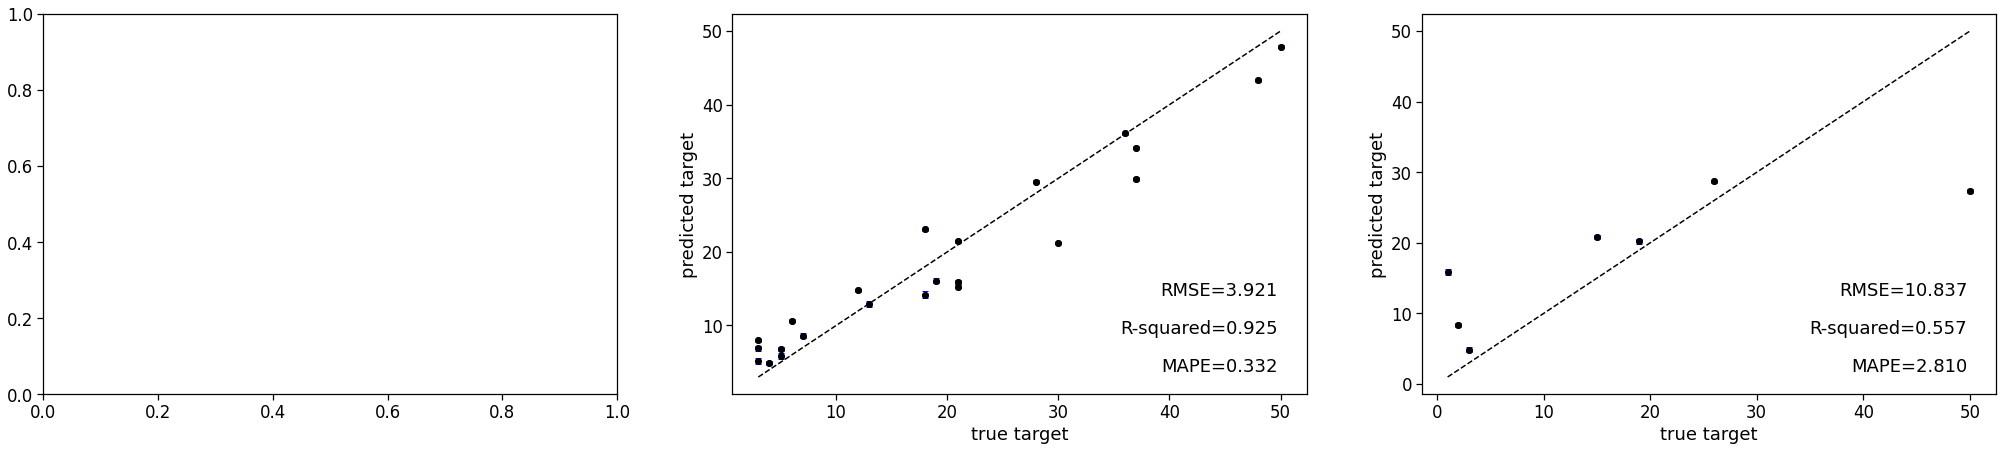

In [909]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})
fig, axs = plt.subplots(1, 3, figsize=(35, 7))
axs = axs.ravel()
plot_model(axs)

132
132


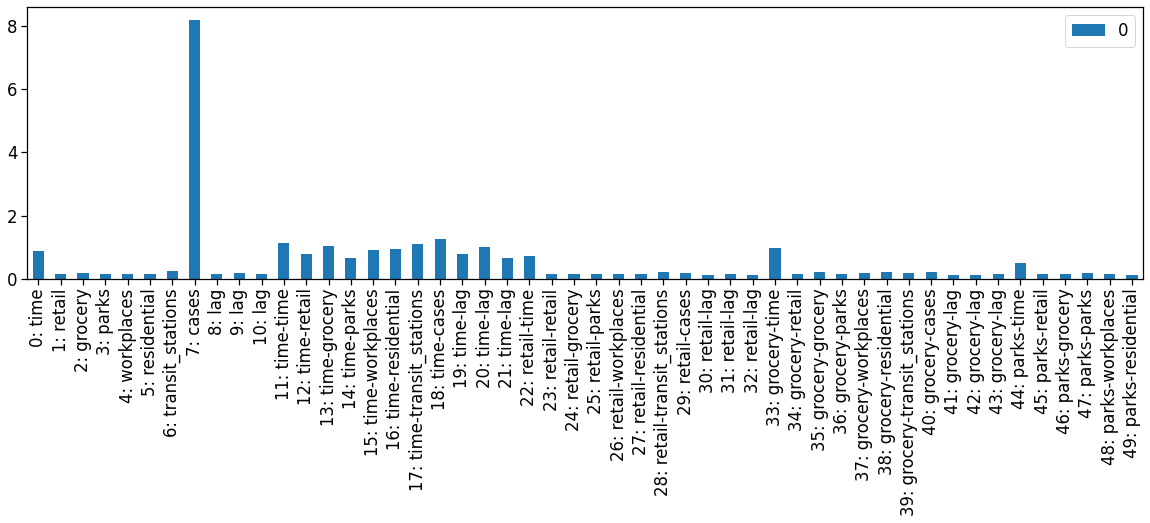

In [210]:
lengthscales = model.kernel.trainable_parameters[0].numpy()[:50]

keys = get_sig_keys(11, level_sig)

dico = {'1':'time','2':'retail','3':'grocery','4':'parks','5':'workplaces','6':'residential','7':'transit_stations','8':'cases','9':'lag','10':'lag','11':'lag'}
features_names = []


print(features.shape[1])
print(len(keys))

for i in range(features.shape[1]):
    separator = '-'
    name = separator.join([dico[e] for e in keys[i]])
    features_names.append(str(i)+': '+name)

fig, ax = plt.subplots(1,figsize=(20,5))
lengthscales = pd.DataFrame([1./e for e in lengthscales][:50])
lengthscales.index = features_names[:50]
lengthscales.plot(kind='bar',ax=ax,rot=90)
plt.show()



In [ ]:
dico = pickle.load()